# NodeNorm Log Analysis

As of [PR #312](https://github.com/TranslatorSRI/NodeNormalization/pull/312), NodeNorm produces logs in the format:

```
2025-06-18T03:26:30-04:00	2025-06-18 07:26:30,635 | INFO | normalizer:get_normalized_nodes | Normalized 1 nodes in 1.21 ms with arguments (curies=['UMLS:C0132098'], conflate_gene_protein=True, conflate_chemical_drug=True, include_descriptions=False, include_individual_types=True)
```

This Jupyter Notebook is intended to be used in analysing these logs.

## Install prerequisites

In [1]:
%pip install pandas matplotlib numpy seaborn

  Using cached matplotlib-3.10.8-cp314-cp314-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached numpy-2.4.2-cp314-cp314-macosx_14_0_arm64.whl.metadata (6.6 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.3-cp314-cp314-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp314-cp314-macosx_10_15_universal2.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp314-cp314-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 66.9 MB/s  0:00:00
Using cached matplotlib-3.10.8-cp314-cp314-macosx_11_0_arm64.whl (8.2 MB)
Using cached numpy-2.4.2-cp314-cp314-macosx_14_0_arm64.whl (5.2 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.3-cp314-cp314-macosx_11_0_arm64.whl (273 kB)
Using cached cycler-0.12.1-py3-none-any.whl

## Loading files

These files can be checked into the repository into the `logs/` subdirectory.

In [9]:
logfiles_json_tar_gz = [
    "./logs/data/pjl-upload/node-normalization-web-logs-2025-11.tar.gz",
    "./logs/data/pjl-upload/node-normalization-web-logs-2025-12.tar.gz",
    "./logs/data/pjl-upload/node-normalization-web-logs-2026-01.tar.gz",
]

We can use Python dataclasses to load the important information from the logfile.

In [17]:
import json
from dataclasses import dataclass
from datetime import datetime
import csv
import gzip
import logging
import re
import ast
import statistics

In [10]:
logging.basicConfig(level=logging.INFO)

@dataclass
class LogEntry:
    time: datetime
    curies: list[str]
    curie_count: int
    time_taken_ms: float
    time_taken_per_curie_ms: float
    arguments: dict[str, str]
    node: str = ""

def convert_log_line_into_entry(line: str) -> list[LogEntry]:
    # Depending on where the log file comes from, it might start with one of two types of timestamps:
    # - ISO 8601 date (e.g. "2007-04-05T12:30−02:00"), which will be separated from the rest of the log line with a tab character.
    # - Python log format date (e.g. "2025-06-12 13:01:49,319"), which should always be in UTC.

    # Entry variables.
    log_time = None
    curies = []
    curie_count = -1
    time_taken_ms = -1.0
    arguments = {}

    # Parse the datetime stamp.
    iso8601date_match = re.match(r'^(\d{4}-\d{2}-\d{2}(?:[T ]\d{2}:\d{2}(?::\d{2}(?:[\.,]\d+)?(?:Z|[+-]\d{2}:\d{2})?)?)?) |', line)
    if iso8601date_match:
        log_time = datetime.fromisoformat(iso8601date_match.group(1))
    else:
        raise ValueError(f"Could not identify the datetime for the line: '{line}'")

    # Is the log line too long?
    if len(line) > 49_151: # Longest we've seen is 114688, and that was truncated.
        return []

    # Parse the log text.
    log_text_match = re.search(r'\| INFO \| normalizer:get_normalized_nodes \| Normalized (\d+) nodes in ([\d\.]+) ms with arguments \((.*)\)', line)
    if not log_text_match:
        raise ValueError(f"Could not find NodeNorm log-line (length: {len(line)}): {line}")
    curie_count = int(log_text_match.group(1))
    time_taken_ms = float(log_text_match.group(2))
    argument_text = log_text_match.group(3)

    # To parse the argument_text, we can turn it into a function call and use Python's ast module to parse it.
    argument_fn_call = f'arguments({argument_text})'
    tree = ast.parse(argument_fn_call, mode="eval")
    call_node = tree.body
    for kw in call_node.keywords:
        arguments[kw.arg] = ast.literal_eval(kw.value)

    # Some assertions.
    if 'curies' not in arguments:
        raise ValueError(f'No CURIEs found in arguments {argument_text} on line {line}, which was parsed into: {arguments}')
    curies = arguments['curies']
    if len(curies) != curie_count:
        raise ValueError(f'Found {len(curies)} CURIEs in arguments but expected {curie_count} CURIEs: {curies}')
    if len(curies) < 1:
        raise ValueError(f'Found no CURIEs in line: {line}')

    # Emit the LogEntry.
    return [LogEntry(
        time=log_time,
        curies=curies,
        curie_count=curie_count,
        time_taken_ms=time_taken_ms,
        time_taken_per_curie_ms=time_taken_ms/curie_count,
        arguments=arguments
    )]

In [11]:
import urllib
import io
import tarfile

logs = []
count_skipped = 0
for logfile_json_tar_gz in logfiles_json_tar_gz:
    logline_count = 0
    with tarfile.open(logfile_json_tar_gz, "r|gz") as tar:
        print(f"Loading logfile {logfile_json_tar_gz}")

        for member in tar:
            if member.isfile():
                if not member.name.lower().endswith(".json"):
                    print(f"Skipping member {member}")
                    continue
                
                logf = tar.extractfile(member)
        
                # The entire log file from AWS is one massive JSON list *curses*.
                datas = json.load(logf)

                for data in datas:
                    if len(data) > 2:
                        raise ValueError(f"Invalid data: expected query and results, but got: {json.dumps(data)}")

                    # print(f"Processing data: {json.dumps(data)}")
                    
                    query = data[0]
                    results = data[1]
                    
                    for result in results['data']['result']:
                        # print(f"Processing result: {result}")
    
                        # Each JSON file from the Sterling logs consists of multiple entries.
                        # Each entry has a values field, which is a list of rows.
                        # Each row is a list with two items: a timestamp and a log line.
                        for value in result['values']:
                            [_, line] = value
                        
                            # We're only interested in log-lines -- these will all contain `normalizer:get_normalized_nodes`
                            if "normalizer:get_normalized_nodes" not in line:
                                print(f"SKIPPING line '{line}' because it isn't one of interest.")
                                count_skipped += 1
                                continue
    
                            logs.extend(convert_log_line_into_entry(line))
                            logline_count += 1
      print(f"Loaded {logline_count} lines from {logfile_json_tar_gz}")
    
print(f"Loaded {len(logs):,} log entries in total, skipped {count_skipped} lines.")

Loading logfile ./logs/data/pjl-upload/node-normalization-web-logs-2025-11.tar.gz
Skipping member <TarInfo '2025-11/loki_query_results_node-normalization-web-2025-11-19-08.csv' at 0x10d323580>
Skipping member <TarInfo '2025-11/loki_query_results_node-normalization-web-2025-11-19-20.csv' at 0x10d322e00>
Skipping member <TarInfo '2025-11/loki_query_results_node-normalization-web-2025-11-28-00.csv' at 0x10d2a9b40>
Skipping member <TarInfo '2025-11/loki_query_results_node-normalization-web-2025-11-26-05.csv' at 0x10c405780>
Skipping member <TarInfo '2025-11/loki_query_results_node-normalization-web-2025-11-26-11.csv' at 0x10c4056c0>
Skipping member <TarInfo '2025-11/loki_query_results_node-normalization-web-2025-11-23-09.csv' at 0x10c405600>
Skipping member <TarInfo '2025-11/loki_query_results_node-normalization-web-2025-11-24-00.csv' at 0x10c405300>
Skipping member <TarInfo '2025-11/loki_query_results_node-normalization-web-2025-11-24-14.csv' at 0x10c405540>
Skipping member <TarInfo '2025

In [12]:
logs[:10]

[LogEntry(time=datetime.datetime(2025, 11, 20, 1, 6, 17, 649000), curies=['orphanet:33110'], curie_count=1, time_taken_ms=4.23, time_taken_per_curie_ms=4.23, arguments={'curies': ['orphanet:33110'], 'conflate_gene_protein': True, 'conflate_chemical_drug': False, 'include_descriptions': False, 'include_individual_types': False}, node=''),
 LogEntry(time=datetime.datetime(2025, 11, 20, 1, 6, 21, 713000), curies=['MONDO:0000429'], curie_count=1, time_taken_ms=4.19, time_taken_per_curie_ms=4.19, arguments={'curies': ['MONDO:0000429'], 'conflate_gene_protein': True, 'conflate_chemical_drug': False, 'include_descriptions': False, 'include_individual_types': False}, node=''),
 LogEntry(time=datetime.datetime(2025, 11, 20, 1, 6, 25, 725000), curies=['MONDO:0700096'], curie_count=1, time_taken_ms=4.81, time_taken_per_curie_ms=4.81, arguments={'curies': ['MONDO:0700096'], 'conflate_gene_protein': True, 'conflate_chemical_drug': False, 'include_descriptions': False, 'include_individual_types': Fa

# Some overall measures

In [ ]:
times = sorted(list(set(map(lambda x: x.time, logs))))
count_requests = len(logs)
unique_curies = sorted(set([x for xs in map(lambda x: x.curies, logs) for x in xs]))

In [54]:
time_taken_ms = list(map(lambda x: x.time_taken_ms, logs))
time_taken_per_curie_ms = list(map(lambda x: x.time_taken_per_curie_ms, logs))
curie_count = list(map(lambda x: x.curie_count, logs))

print(f"Time range: {times[0]} to {times[-1]} ({times[-1] - times[0]})")
print(f"Total number of requests: {count_requests:,}")
print(f"Total number of CURIEs: {sum(curie_count):,}")
print(f"Minimum number of CURIEs: {min(curie_count):,}")
print(f"Mean number of CURIEs: {sum(curie_count)/count_requests}")
print(f"Median number of CURIEs: {statistics.median(curie_count)}")
print(f"Modal number of CURIEs: {statistics.mode(curie_count)}")
print(f"Maximum number of CURIEs: {max(curie_count):,}")
print(f"Total time taken: {sum(map(lambda x: x.time_taken_ms, logs)):,} ms")
print(f"Minimum time per request: {min(time_taken_ms)} ms")
print(f"Average time per request: {sum(time_taken_ms)/count_requests} ms")
print(f"Maximum time per request: {max(time_taken_ms)} ms")
print(f"Minimum time per CURIE: {min(time_taken_per_curie_ms)} ms")
print(f"Average time per CURIE: {sum(time_taken_per_curie_ms)/count_requests} ms")
print(f"Maximum time per CURIE: {max(time_taken_per_curie_ms)} ms")
print(f"Total number of unique CURIEs: {len(unique_curies):,}")

Time range: 2025-11-06 05:00:21.176000 to 2026-02-01 04:59:59.749000 (86 days, 23:59:38.573000)
Total number of requests: 4,823,177
Total number of CURIEs: 78,392,602
Minimum number of CURIEs: 1
Mean number of CURIEs: 16.25331228773068
Median number of CURIEs: 1
Modal number of CURIEs: 1
Maximum number of CURIEs: 2,897
Total time taken: 25,194,031.67 ms
Minimum time per request: 0.08 ms
Average time per request: 5.223534543725018 ms
Maximum time per request: 3865.78 ms
Minimum time per CURIE: 0.0024 ms
Average time per CURIE: 1.7612865864157383 ms
Maximum time per CURIE: 720.31 ms
Total number of unique CURIEs: 21,044,236


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import asdict

# Assume `records` is your list of dataclass instances
# Convert to DataFrame
df = pd.DataFrame([asdict(r) for r in logs])
df['curie_count'] = df['curie_count'].astype(int)
df['time'] = pd.to_datetime(df['time'])
df['throughput_cps'] = df['curie_count'] / df['time_taken_ms'] * 1000
print(f"Throughput: {df['throughput_cps'].mean()} (min: {df['throughput_cps'].min()}, max: {df['throughput_cps'].max()}) CURIES per second")

Throughput: 7990.545713069824 (min: 1.3882911524204857, max: 416666.6666666667) CURIES per second


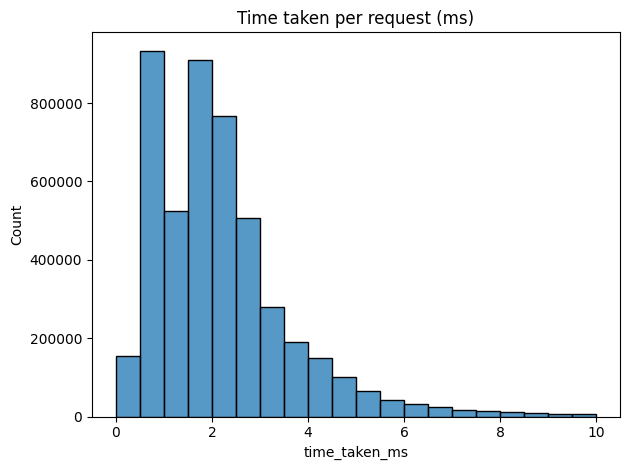

In [30]:
sns.histplot(df['time_taken_ms'], bins=20, kde=False, binrange=(0, 10)) #100))
plt.title("Time taken per request (ms)")
plt.tight_layout()
plt.show()

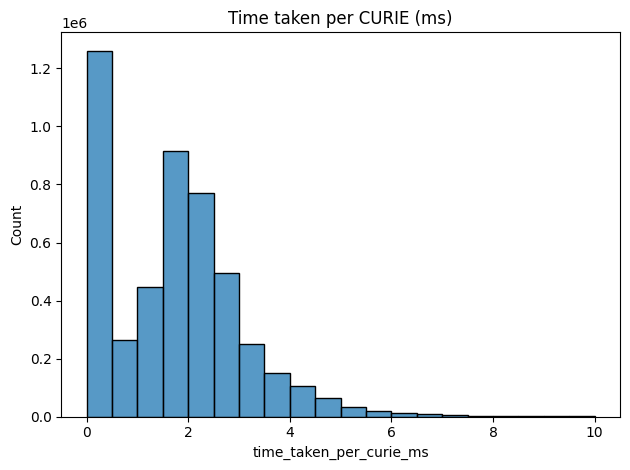

In [31]:
sns.histplot(df['time_taken_per_curie_ms'], bins=20, kde=False, binrange=(0, 10)) #100))
plt.title("Time taken per CURIE (ms)")
plt.tight_layout()
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


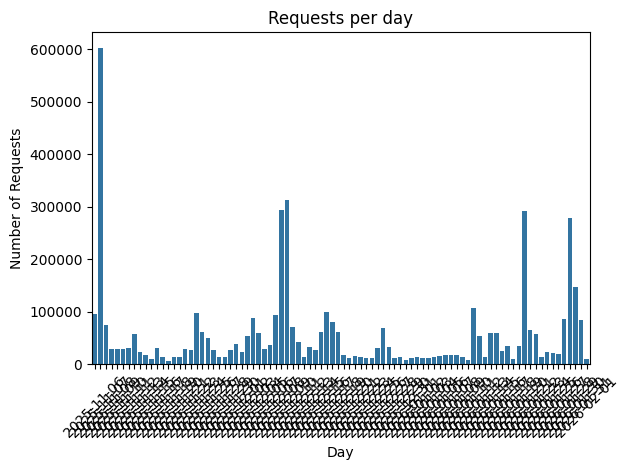

In [39]:
# Plot requests against time.
requests_per_hour = df.set_index('time').resample('D').size()
sns.barplot(x=requests_per_hour.index, y=requests_per_hour.values)
plt.title("Requests per day")
plt.xlabel("Day")
plt.ylabel("Number of Requests")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

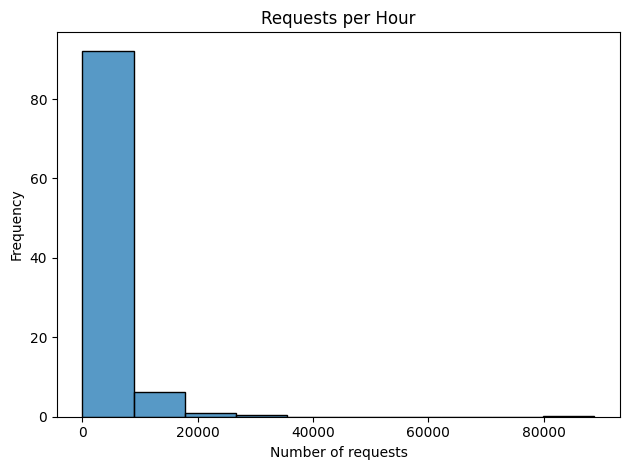

In [41]:
# Plot the frequency distribution of requests grouped by hour.
curies_per_hour = df.set_index('time').resample('h').size()
sns.histplot(curies_per_hour, bins=10, stat='percent')
plt.title("Requests per Hour")
plt.xlabel("Number of requests")
plt.ylabel("Frequency")
plt.tight_layout()

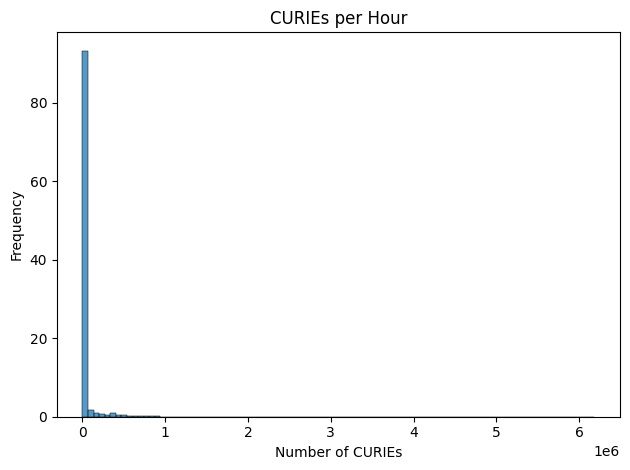

In [45]:
# Plot the frequency distribution of CURIE counts grouped by hour.
# TODO: fix this graph
curies_per_hour = df.set_index('time').resample('h')['curie_count'].sum()
sns.histplot(curies_per_hour, stat='percent')
plt.title("CURIEs per Hour")
plt.xlabel("Number of CURIEs")
plt.ylabel("Frequency")
plt.tight_layout()

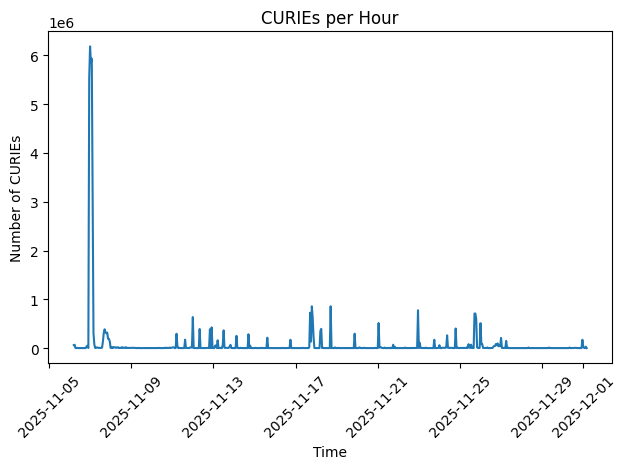

In [29]:
# Plot CURIEs over time (by hour)
# Fix this graph
curies_per_hour = df.set_index('time').resample('h')['curie_count'].sum()
sns.lineplot(x=curies_per_hour.index, y=curies_per_hour.values)
plt.title("CURIEs per Hour")
plt.xlabel("Time")
plt.ylabel("Number of CURIEs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


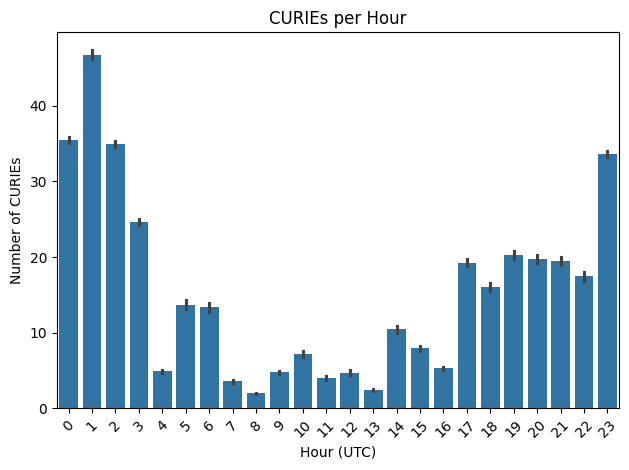

In [46]:
# Plot CURIEs against hour of day
df['hour_of_day'] = df['time'].dt.hour
sns.barplot(data=df, x='hour_of_day', y='curie_count')
plt.title("CURIEs per Hour")
plt.xlabel("Hour (UTC)")
plt.ylabel("Number of CURIEs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

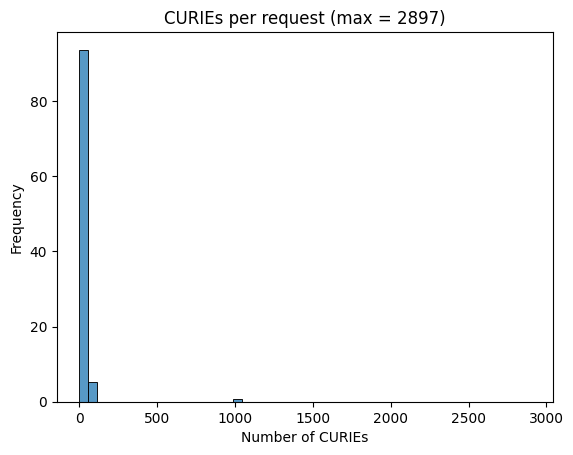

In [47]:
# CURIEs per request
sns.histplot(df['curie_count'], bins=50, stat='percent')
plt.title(f"CURIEs per request (max = {max(df['curie_count'])})")
plt.xlabel("Number of CURIEs")
plt.ylabel("Frequency")
plt.show()

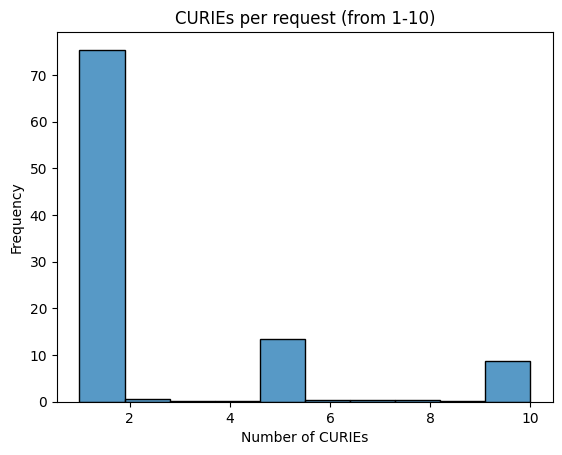

In [48]:
# CURIEs per request (but only from 1-10)
sns.histplot(df['curie_count'], bins=10, binrange=(1, 10), stat='percent')
plt.title("CURIEs per request (from 1-10)")
plt.xlabel("Number of CURIEs")
plt.ylabel("Frequency")
plt.show()

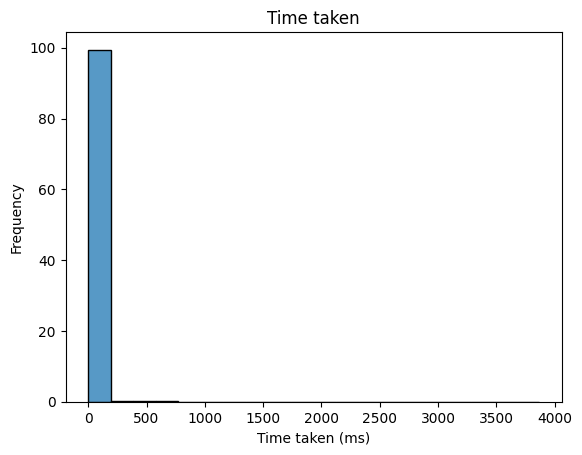

In [51]:
# Time taken distribution
sns.histplot(df['time_taken_ms'], bins=20, stat="percent")
plt.title("Time taken")
plt.xlabel("Time taken (ms)")
plt.ylabel("Frequency")
plt.show()

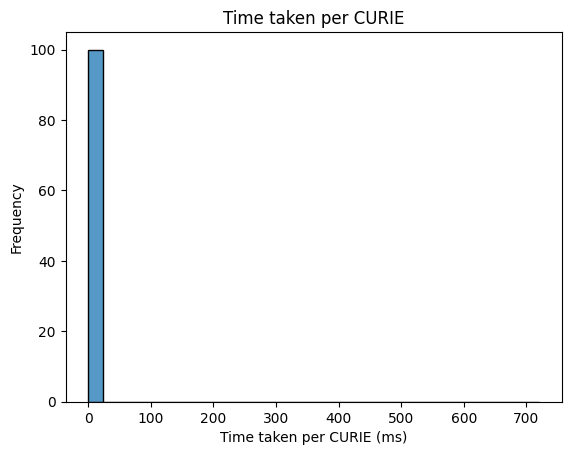

In [52]:
# Time per CURIE distribution
# CURIEs per request
sns.histplot(df['time_taken_per_curie_ms'], bins=30, stat="percent")
plt.title("Time taken per CURIE")
plt.xlabel("Time taken per CURIE (ms)")
plt.ylabel("Frequency")
plt.show()